In [62]:
import numpy as np
import pandas as pd
import sklearn

In [63]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
y_test = pd.read_csv("sample_submission.csv")
nrows = len(train)

In [64]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [65]:
eda = pd.DataFrame(columns = ["Mean", "Variance", "Quartile1", "Median", "Quartile3"])
eda["Mean"] = train.mean()
eda["Variance"] = train.var()
eda["Quartile1"] = train.quantile(0.25)
eda["Median"] = train.quantile(0.5)
eda["Quartile3"] = train.quantile(0.75)
print(eda)

                        Mean      Variance  Quartile1    Median  Quartile3
Id                730.500000  1.777550e+05     365.75     730.5    1095.25
MSSubClass         56.897260  1.789338e+03      20.00      50.0      70.00
LotFrontage        70.049958  5.897492e+02      59.00      69.0      80.00
LotArea         10516.828082  9.962565e+07    7553.50    9478.5   11601.50
OverallQual         6.099315  1.912679e+00       5.00       6.0       7.00
OverallCond         5.575342  1.238322e+00       5.00       5.0       6.00
YearBuilt        1971.267808  9.122154e+02    1954.00    1973.0    2000.00
YearRemodAdd     1984.865753  4.262328e+02    1967.00    1994.0    2004.00
MasVnrArea        103.685262  3.278497e+04       0.00       0.0     166.00
BsmtFinSF1        443.639726  2.080255e+05       0.00     383.5     712.25
BsmtFinSF2         46.549315  2.602391e+04       0.00       0.0       0.00
BsmtUnfSF         567.240411  1.952464e+05     223.00     477.5     808.00
TotalBsmtSF      1057.429

/var/folders/jp/f4f083112sscgnyk35l8yjgh0000gn/T/ipykernel_43623/694865173.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  eda["Mean"] = train.mean()
/var/folders/jp/f4f083112sscgnyk35l8yjgh0000gn/T/ipykernel_43623/694865173.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  eda["Variance"] = train.var()


In [66]:
toDrop = []
for i in range(len(train.columns)):
    if train[train.columns[i]].isna().sum() > 0.3*nrows:
        toDrop.append(train.columns[i])
toDrop

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [67]:
naAllowed = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
            "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC",
            "Fence", "MiscFeature"]
for allowed in naAllowed:
    train[allowed] = train[allowed].fillna("NA")

In [68]:
colHasNA = []
for i in range(len(train.columns)):
    if train[train.columns[i]].isna().sum() > 0:
        colHasNA.append((train.columns[i], train[train.columns[i]].isna().sum()))
print(colHasNA)

[('LotFrontage', 259), ('MasVnrType', 8), ('MasVnrArea', 8), ('Electrical', 1), ('GarageYrBlt', 81)]


In [69]:
# Got rid of missing values
trainClean = train.dropna()
y_train = trainClean["SalePrice"]
trainClean = trainClean.drop("SalePrice", axis = 1)


In [71]:
trainClean.index = np.arange(0, len(trainClean), 1)

In [72]:
# Many of the year variables, once OHE'd will be sparse, so grouping them
yearVars = ["YrSold", "YearBuilt", "YearRemodAdd", "GarageYrBlt"]
for var in yearVars:
    trainClean[var + "_simplified"] = trainClean[var] - trainClean[var] % 10
    trainClean = trainClean.drop(var, axis = 1)

In [73]:
# OHE
from sklearn.preprocessing import OneHotEncoder
numericVars = set(["LotFrontage", "LotArea", "OverallQual", "OverallCond",
               "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF",
               "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
               "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "FullBath", 
               "HalfBath", "Bedroom", "Kitchen", "TotRmsAbvGrd",
               "Fireplaces", "GarageCars", "GarageArea", "WoodDeckSF",
               "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch",
               "PoolArea", "MiscVal", "SalePrice"])

theOriginal = trainClean.columns
# for i in range(1, len(theOriginal)):
#     currCol = theOriginal[i]
#     if currCol not in numericVars and currCol not in yearVars:
#         one_hot = pd.get_dummies(trainClean[currCol])
#         dOHE[currCol] = one_hot.columns
#         one_hot = one_hot.add_suffix('_' + currCol)
#         trainClean = trainClean.drop(currCol, axis = 1)
#         trainClean = pd.concat([trainClean, one_hot], axis = 1)

categoricals = pd.DataFrame()
for i in range(1, len(theOriginal)):
    currCol = theOriginal[i]
    if currCol not in numericVars and currCol not in yearVars:
        categoricals[currCol] = trainClean[currCol]
        trainClean = trainClean.drop(currCol, axis = 1)

ohe = OneHotEncoder(handle_unknown = 'ignore')
ohe.fit(categoricals)
new_categories = pd.DataFrame(ohe.transform(categoricals).toarray())
print(new_categories)
trainClean = trainClean.join(new_categories)
trainClean.head()

      0    1    2    3    4    5    6    7    8    9    ...  314  315  316  \
0     0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1115  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1116  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1117  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  1.0   
1118  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1119  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

      317  318  319  320  321  322  323  
0     0.0  0.0  0.0  

,Id,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,314,315,316,317,318,319,320,321,322,323
0,1,65.0,8450,7,5,196.0,706,0,150,856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,80.0,9600,6,8,0.0,978,0,284,1262,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,68.0,11250,7,5,162.0,486,0,434,920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,60.0,9550,7,5,0.0,216,0,540,756,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,84.0,14260,8,5,350.0,655,0,490,1145,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [75]:
# Checking Sparsity - we will need PCA

# for i in range(len(train.columns)):
#     if len(train[train.columns[i]].unique()) > 700:
#         print(train.columns[i])
count = 0
for i in range(len(trainClean.columns)):
    if np.count_nonzero(trainClean[trainClean.columns[i]]) < 100:
        count += 1
        print(trainClean.columns[i])
        print(np.count_nonzero(trainClean[trainClean.columns[i]]))
print(count)

LowQualFinSF
17
BsmtHalfBath
61
3SsnPorch
18
ScreenPorch
95
PoolArea
6
MiscVal
34
1
47
2
3
3
9
6
52
7
13
8
37
9
14
10
35
11
66
12
53
13
6
14
19
15
8
16
54
17
10
20
4
22
41
24
36
26
26
27
7
29
47
30
44
31
15
35
44
36
30
37
4
40
44
41
5
42
14
43
2
44
15
45
42
46
12
48
41
49
71
50
49
51
27
52
10
53
32
55
7
56
45
57
33
58
75
59
97
60
19
61
46
62
48
63
75
64
20
65
29
66
7
67
43
68
56
70
4
71
9
72
9
73
24
74
1
75
4
76
2
77
5
79
1
80
2
81
2
83
20
84
35
85
35
86
90
88
10
90
6
91
9
93
24
94
43
95
6
97
10
99
6
100
1
102
1
103
1
104
6
105
2
106
6
107
14
108
2
109
40
110
1
111
45
113
1
115
68
116
1
117
19
120
22
121
15
122
2
123
7
124
21
125
1
126
45
128
9
130
1
131
87
132
4
133
20
136
29
137
9
141
46
142
7
145
2
146
17
152
15
153
6
154
2
156
32
158
24
160
36
161
51
162
24
163
1
166
97
167
89
168
25
173
56
174
24
177
13
178
25
179
12
180
35
181
25
182
37
185
17
186
2
187
1
188
3
190
30
192
1
194
63
196
70
197
20
198
2
199
1
201
4
202
28
206
14
207
4
209
46
210
1
211
91
212
22
215
10
216
4
217
24
2

In [76]:
# Scaling Vars
for i in range(len(trainClean.columns)):
    if trainClean.columns[i] in numericVars:
        minimum = trainClean[trainClean.columns[i]].min()
        maximum = trainClean[trainClean.columns[i]].max()
        if minimum != maximum:
            trainClean[trainClean.columns[i]] = (trainClean[trainClean.columns[i]] - trainClean[trainClean.columns[i]].min())/(trainClean[trainClean.columns[i]].max() - trainClean[trainClean.columns[i]].min())

In [77]:
# AllPub_Utilities has only "1" values, so remove

if "AllPub_Utilities" in trainClean.columns:
    trainClean["AllPub_Utilities"].unique()
    trainClean = trainClean.drop("AllPub_Utilities", axis = 1)

In [78]:
# Cleaning test data and OHE function
        
def cleanData(dataset):
    if "AllPub_Utilities" in dataset.columns:
        dataset = dataset.drop("AllPub_Utilities", axis = 1)
    for allowed in naAllowed:
        dataset[allowed] = dataset[allowed].fillna("NA")
    for col in dataset.columns:
        if col in numericVars:
            dataset[col] = dataset[col].fillna(dataset[col].mean())
        else:
            if dataset[col].mode()[0]:
                dataset[col] = dataset[col].fillna(dataset[col].mode()[0])
            else:
                dataset[col] = dataset[col].fillna(dataset[col].mode())
    
    for var in yearVars:
        dataset[var + "_simplified"] = dataset[var] - dataset[var] % 10
        dataset = dataset.drop(var, axis = 1)
    
    theOriginal = dataset.columns
    categoricals = pd.DataFrame()
    for i in range(1, len(theOriginal)):
        currCol = theOriginal[i]
        if currCol not in numericVars and currCol not in yearVars:
            categoricals[currCol] = dataset[currCol]
#             one_hot = pd.get_dummies(dataset[currCol])
#             one_hot = one_hot.add_suffix('_' + currCol)
            dataset = dataset.drop(currCol, axis = 1)
#             dataset = pd.concat([dataset, one_hot], axis = 1)
    new_categories = pd.DataFrame(ohe.transform(categoricals).toarray())
    dataset = dataset.join(new_categories)
    return dataset

testClean = test
testClean = cleanData(testClean)

In [83]:
# Testing Multicollinearity
import sys
np.set_printoptions(threshold=sys.maxsize)

from statsmodels.stats.outliers_influence import variance_inflation_factor

trainClean.corr()

vif_data = pd.DataFrame() 
vif_data["feature"] = trainClean.columns 
result = []
for i in range(len(trainClean.columns)):
    # print(trainClean.columns[i])
    if variance_inflation_factor(trainClean.values, i):
        result.append(variance_inflation_factor(trainClean.values, i))
    else:
        print(trainClean.columns[i])
        result.append(pd.NA)
            
vif_data["VIF"] = result
print(result)

33
[1.3233453545910647, 4.08184943205402, 3.314100629660007, 7.221797518016392, 3.6169538296757224, 3.502269645215476, inf, inf, inf, inf, inf, inf, inf, inf, 3.3256607737725363, 1.6363469225865317, 5.346881192423876, 3.799504402637922, 7.785614001253636, 9.415181498892604, 6.977720457779371, 7.2331041786888, 1.761459525291176, 2.0841319172956188, 2.194982215445369, 1.2476161033375195, 1.6461880283585608, 4422.62204884828, 5.672193093583222, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, <NA>, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf

In [64]:
## PCA + Model Training

In [84]:
# Remove Id
trainClean = trainClean.drop("Id", axis = 1)
trainClean.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,314,315,316,317,318,319,320,321,322,323
0,0.150685,0.033420,0.625,0.428571,0.12250,0.125089,0.0,0.064212,0.140098,0.098260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.202055,0.038795,0.500,0.857143,0.00000,0.173281,0.0,0.121575,0.206547,0.193700,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.160959,0.046507,0.625,0.428571,0.10125,0.086109,0.0,0.185788,0.150573,0.113305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.133562,0.038561,0.625,0.428571,0.00000,0.038271,0.0,0.231164,0.123732,0.122943,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.215753,0.060576,0.750,0.428571,0.21875,0.116052,0.0,0.209760,0.187398,0.166197,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


[0.14771054 0.05457183 0.04432251 0.0314231  0.02870551 0.02669806
 0.02144991 0.01920427 0.01796188 0.01693464 0.01680209 0.01631585
 0.01483606 0.0145168  0.01412279 0.01350514 0.01277671 0.0122449
 0.01183557 0.01123567 0.01120126 0.01091972 0.01043213 0.00999059
 0.00989149 0.00972076 0.00929389 0.00912191 0.00903004 0.00864853
 0.00823526 0.00804705 0.00762676 0.00751966 0.00732084 0.0071455
 0.00694862 0.00680565 0.00648765 0.00624151 0.00599439 0.0058767
 0.00576507 0.00551129 0.00546795 0.00538869 0.0052067  0.00504177
 0.00493223 0.00489977 0.00481758 0.0047371  0.0045153  0.00443304
 0.00440702 0.00426475 0.004123   0.00404587 0.00395716 0.0038315
 0.00382105 0.00375513 0.00361949 0.00351712 0.00343556 0.00335907
 0.00328294 0.00318097 0.00317213 0.00304923 0.00304769 0.00299858
 0.00287288 0.00286589 0.00273266 0.00272475 0.00264491 0.00260597
 0.00244648 0.00237494]


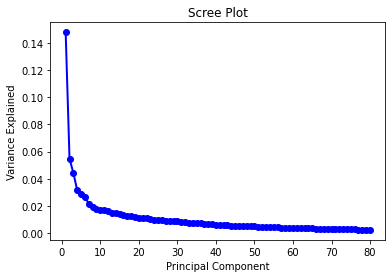

In [85]:
# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components = 80)
trainClean_pca = pca.fit_transform(trainClean)
print(pca.explained_variance_ratio_)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [89]:
testClean = testClean.drop("Id", axis = 1)
testClean_pca = pca.transform(testClean)

/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [90]:
# LinReg Training
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(trainClean_pca)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     62.45
Date:                Sat, 06 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:30:54   Log-Likelihood:                -13290.
No. Observations:                1120   AIC:                         2.674e+04
Df Residuals:                    1039   BIC:                         2.715e+04
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.855e+05   1068.371    173.650      0.0

In [91]:
# Lasso Regression Training
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha' : [1, 2, 5, 10, 50, 100]
}
lasso = Lasso(alpha=1,normalize=True, max_iter=1e5)

lasso_CV = GridSearchCV(estimator=lasso, param_grid=param_grid, n_jobs=-1, cv=None, verbose=1)
lasso_CV.fit(trainClean_pca, y_train)
print(lasso_CV.best_params_)

lassoreg = Lasso(alpha=10,normalize=True, max_iter=1e5)
lassoreg.fit(trainClean_pca,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

fro

{'alpha': 10}


 scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as 

Lasso(alpha=10, max_iter=100000.0, normalize=True)

(
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

In [93]:
# Random Forest Hyperparam Tuning
from sklearn.ensemble import RandomForestRegressor

param_grid = {'min_samples_split' : [3, 5, 10],
              'max_depth' : [25, 50, 100],
              'n_estimators' : [100, 250, 500]}

rfr = RandomForestRegressor(n_estimators = 100, random_state = 42)

rf_CV = GridSearchCV(estimator=rfr, param_grid=param_grid, n_jobs=-1, cv=None, verbose=1)
rf_CV.fit(trainClean_pca, y_train)

rf_results = pd.DataFrame(rf_CV.cv_results_).sort_values(by=['rank_test_score'])
display(rf_results)

print(rf_CV.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,7.234632,0.282263,0.018860,0.004896,50,3,250,"{'max_depth': 50, 'min_samples_split': 3, 'n_e...",0.760342,0.760976,0.719748,0.801450,0.719870,0.752477,0.030551,1
19,7.216268,0.082150,0.017084,0.003101,100,3,250,"{'max_depth': 100, 'min_samples_split': 3, 'n_...",0.760342,0.760976,0.719748,0.801450,0.719870,0.752477,0.030551,1
1,6.469624,0.043699,0.019197,0.004497,25,3,250,"{'max_depth': 25, 'min_samples_split': 3, 'n_e...",0.760342,0.760976,0.719748,0.801400,0.719870,0.752467,0.030535,3
20,14.217581,0.136858,0.039982,0.007997,100,3,500,"{'max_depth': 100, 'min_samples_split': 3, 'n_...",0.757609,0.762402,0.723485,0.805903,0.711277,0.752135,0.033216,4
11,16.029876,0.191453,0.038763,0.004393,50,3,500,"{'max_depth': 50, 'min_samples_split': 3, 'n_e...",0.757609,0.762402,0.723485,0.805903,0.711277,0.752135,0.033216,4
2,13.127052,0.168510,0.034906,0.004198,25,3,500,"{'max_depth': 25, 'min_samples_split': 3, 'n_e...",0.757578,0.762402,0.723485,0.805895,0.711277,0.752127,0.033213,6
3,2.522702,0.031796,0.007288,0.003382,25,5,100,"{'max_depth': 25, 'min_samples_split': 5, 'n_e...",0.758253,0.755756,0.719819,0.800963,0.713888,0.749736,0.031347,7
21,2.708041,0.040670,0.006467,0.001746,100,5,100,"{'max_depth': 100, 'min_samples_split': 5, 'n_...",0.758253,0.755756,0.719819,0.800963,0.713888,0.749736,0.031347,7
12,3.147704,0.102270,0.006860,0.002281,50,5,100,"{'max_depth': 50, 'min_samples_split': 5, 'n_e...",0.758253,0.755756,0.719819,0.800963,0.713888,0.749736,0.031347,7
5,12.873043,0.116164,0.032165,0.002802,25,5,500,"{'max_depth': 25, 'min_samples_split': 5, 'n_e...",0.758747,0.760098,0.720422,0.804488,0.704544,0.749660,0.034894,10


{'max_depth': 50, 'min_samples_split': 3, 'n_estimators': 250}


In [96]:
# Using optimal parameters in RF

rfModel = RandomForestRegressor(n_estimators=250, max_depth = 50, min_samples_split = 3, n_jobs=-1)
rfModel.fit(trainClean_pca, y_train)

RandomForestRegressor(max_depth=50, min_samples_split=3, n_estimators=250,
                      n_jobs=-1)

In [113]:
# Predict and Evaluate
testClean_pca = pca.transform(testClean)

# Make linear reg predictions
testClean_pca_constant = sm.add_constant(testClean_pca)
ypred_linreg = est2.predict(testClean_pca_constant)
print(sum((ypred_linreg-y_test["SalePrice"])**2))

# Make lasso reg predictions
y_pred = lassoreg.predict(testClean_pca)
rss = sum((y_pred-y_test["SalePrice"])**2)

ret = [rss]
ret.extend([lassoreg.intercept_])
ret.extend(lassoreg.coef_)
print(rss)

# make our RF predictions
rf_preds = rfModel.predict(testClean_pca)
print(sum((y_test["SalePrice"]-rf_preds)**2))

1.018696022695571e+19
9.156588116602081e+18
261270059616852.47


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [121]:
# xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Create regression matrices
dtrain_reg = xgb.DMatrix(trainClean_pca, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(testClean_pca, y_test["SalePrice"], enable_categorical=True)
params = {"objective": "reg:squarederror", "tree_method": "hist"}

n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

preds = model.predict(dtest_reg)
print(sum((y_pred-y_test["SalePrice"])**2))

9.156588116602081e+18
